In [1]:
from rgheisenberg.controller import RGController, RGControllerB2
from rgheisenberg import kernels
from rgheisenberg.visualize import plot_coefficients, plot_series, plot_legendre_surface
from rgheisenberg import phase

import numpy as np
import matplotlib.pyplot as plt

/Users/egementunca/rg-heisenberg/src/rgheisenberg/visualize.py:11: SyntaxWarning: invalid escape sequence '\('
  angular Boltzmann weight \(W(\theta)\) over the range
/Users/egementunca/rg-heisenberg/src/rgheisenberg/visualize.py:168: SyntaxWarning: invalid escape sequence '\s'
  $$ W(\theta) = \sum_{\ell=0}^{\ell_{\max}} L_{\ell} P_{\ell}(\cos\theta). $$


In [2]:
def getGvals(J, n_steps):
    gVals = []
    lfc0 = kernels.lfc_initialize(J,21)
    norm0 = np.max(abs(lfc0))
    gVals.append(np.log(norm0))
    lfc_in = lfc0/norm0
    for i in range(n_steps):
        lfc_out, g = kernels.decimate2(lfc_in, lfc_in)
        norm_out = np.max(abs(lfc_out))
        lfc_out = lfc_out/norm_out
        gVals.append(g)
        lfc_in = lfc_out
    factors = 2**(np.arange(len(gVals)))
    return gVals/factors

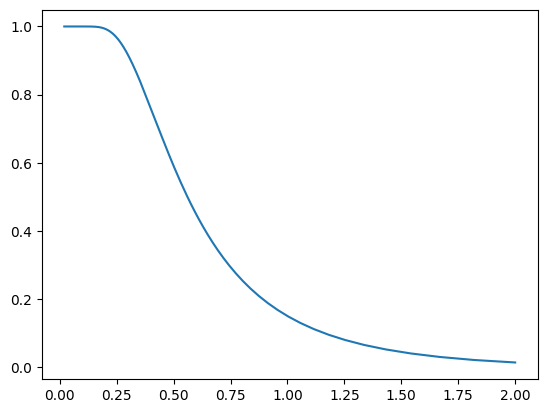

In [3]:
n_steps = 10
eps = 1e-2
specificHeatResults = []
for J in np.linspace(0.2, 50, 1000):
    Jp = J + eps
    Jm = J - eps
    gValsP = getGvals(Jp, n_steps)
    gValsM = getGvals(Jm, n_steps)
    gVals = getGvals(J, n_steps)
    specificHeat = J**2 * (sum(gValsP) -2* sum(gVals) + sum(gValsM))/(eps**2)
    specificHeatResults.append(specificHeat)
plt.plot(1/np.linspace(0.5, 50, 1000), specificHeatResults)
plt.show()

In [4]:
def getGvalsBondMove(J, n_steps, n_bm):
    gVals = []
    lfc0 = kernels.lfc_initialize(J,21)
    norm0 = np.max(abs(lfc0))
    gVals.append(np.log(norm0))
    lfc_in = lfc0/norm0
    for i in range(n_steps):
        lfc_out, g = kernels.decimate2(lfc_in, lfc_in)
        lfc_bond_in = lfc_out
        for j in range(n_bm-1):
            lfc_out, g = kernels.bond_move(lfc_out, lfc_bond_in)
        norm_out = np.max(abs(lfc_out))
        lfc_out = lfc_out/norm_out
        gVals.append(g)
        lfc_in = lfc_out
    factors = 2**(int(np.log2(n_bm) + 1)*np.arange(len(gVals)))
    return gVals/factors

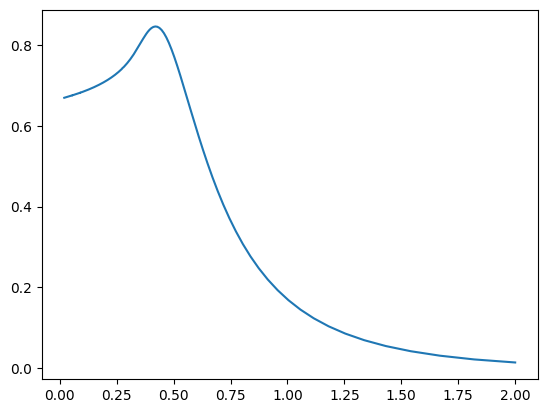

In [5]:
n_steps = 10
n_bm = 2
eps = 1e-2
specificHeatResults = []
for J in np.linspace(0.2, 50, 1000):
    Jp = J + eps
    Jm = J - eps
    gValsP = getGvalsBondMove(Jp, n_steps, n_bm)
    gValsM = getGvalsBondMove(Jm, n_steps, n_bm)
    gVals = getGvalsBondMove(J, n_steps, n_bm)
    specificHeat = J**2 * (sum(gValsP) -2* sum(gVals) + sum(gValsM))/(eps**2)
    specificHeatResults.append(specificHeat)
plt.plot(1/np.linspace(0.5, 50, 1000), specificHeatResults)
plt.show()

In [18]:
def getGvalsBondMoveFirst(J, n_steps, n_bm):
    gVals = []
    lfc0 = kernels.lfc_initialize(J,21)
    norm0 = np.max(abs(lfc0))
    gVals.append(np.log(norm0))
    lfc_in = lfc0/norm0
    for i in range(n_steps):
        _lfc = lfc_in
        for j in range(n_bm-1):
            _lfc, g = kernels.bond_move(_lfc, lfc_in)
        _lfc, g = kernels.decimate2(_lfc, _lfc)
        norm_out = np.max(abs(_lfc))
        _lfc = _lfc/norm_out
        gVals.append(g)
        lfc_in = _lfc
    factors = 2**(int(np.log2(n_bm) + 1)*np.arange(len(gVals)))
    return gVals/factors

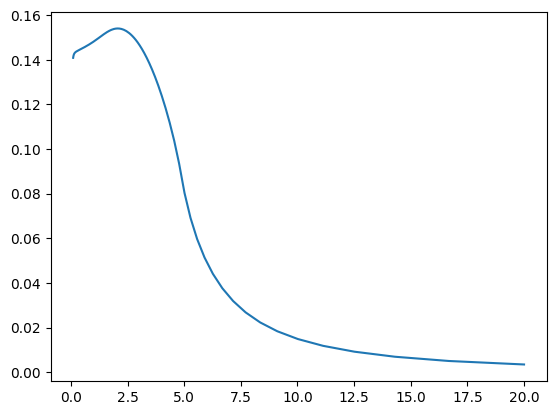

In [35]:
n_steps = 10
n_bm = 4
eps = 1e-3
specificHeatResults = []
for J in np.linspace(0.05, 10, 1000):
    Jp = J + eps
    Jm = J - eps
    gValsP = getGvalsBondMoveFirst(Jp, n_steps, n_bm)
    gValsM = getGvalsBondMoveFirst(Jm, n_steps, n_bm)
    gVals = getGvalsBondMoveFirst(J, n_steps, n_bm)
    specificHeat = J**2 * (sum(gValsP) -2* sum(gVals) + sum(gValsM))/(eps**2)
    specificHeatResults.append(specificHeat)
plt.plot(1/np.linspace(0.05, 10, 1000), specificHeatResults)
plt.show()

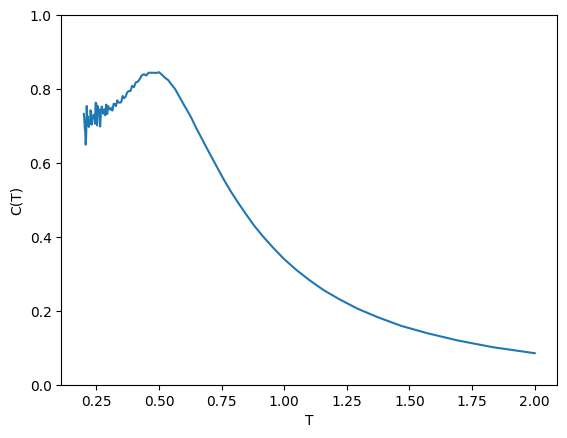

In [55]:
l_prec, pool_size, dim, n_bm = 21, 1, 2, 2   # 2^(d-1)=2 bond moves
steps = 10                                    # same as before

J = np.linspace(0.5, 5, 100)
C = np.empty_like(J)

for k, Jk in enumerate(J):
    beta = Jk
    ctrl = RGControllerB2(l_prec, pool_size, dim, n_bm, bond_move_first=False)   # fresh object
    ctrl.initialize_pool(J=beta, p=0.0, q=0.0)
    ctrl.step(steps)
    C[k] = ctrl.specific_heat(beta)

plt.plot(1/J, C)
plt.xlabel("T"); plt.ylabel("C(T)")
plt.ylim(0, 1)
plt.show()

3 4.868431757200219
4 20.902809538653113
5 84.9067601259449
6 340.88083538489394


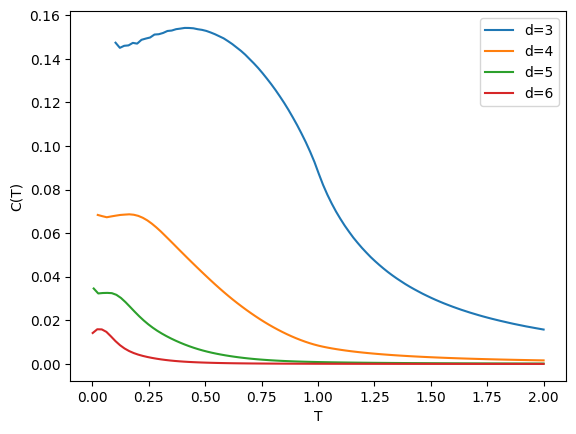

In [32]:
l_prec, pool_size = 21, 1
steps = 10

J = np.linspace(0.5, 5, 100)

for dim in [3,4,5,6]:
    n_bm = 2**(dim-1)
    ctrl = RGControllerB2(l_prec, pool_size, dim, n_bm, bond_move_first=True)
    J_crit = phase.find_critical_J(ctrl_factory=lambda x: ctrl, J_lo=.0001, J_hi=10, p=0.0, q=0.0, steps=20)
    print(dim, 1/J_crit)
    J =1/np.linspace(.5, 2/J_crit, 100)
    C = np.empty_like(J)
    for k, Jk in enumerate(J):
        beta = Jk    
        ctrl.initialize_pool(J=beta, p=0.0, q=0.0)
        ctrl.step(steps)
        C[k] = ctrl.specific_heat(beta)
    plt.plot(J_crit/J, C, label=f"d={dim}")
plt.legend()
plt.xlabel("T"); plt.ylabel("C(T)")
plt.show()

In [2]:
# Critical temperatures vs dimensions 3, 4, 5, 6

# 3D
l_prec, pool_size, dim, n_bm = 21, 1, 3, 4   # 2^(d-1)=4 bond moves
ctrl = RGControllerB2(l_prec, pool_size, dim, n_bm, bond_move_first=True)   # fresh object
print(1/phase.find_critical_J(ctrl_factory=lambda x: ctrl, J_lo=0.0, J_hi=10.0, p=0.0, q=0.0, steps=10))
# 4D
l_prec, pool_size, dim, n_bm = 21, 1, 4, 8   # 2^(d-1)=8 bond moves
ctrl = RGControllerB2(l_prec, pool_size, dim, n_bm, bond_move_first=True)   # fresh object
print(1/phase.find_critical_J(ctrl_factory=lambda x: ctrl, J_lo=0.0, J_hi=10.0, p=0.0, q=0.0, steps=10))

# 5D
l_prec, pool_size, dim, n_bm = 21, 1, 5, 16   # 2^(d-1)=16 bond moves
ctrl = RGControllerB2(l_prec, pool_size, dim, n_bm, bond_move_first=True)   # fresh object
print(1/phase.find_critical_J(ctrl_factory=lambda x: ctrl, J_lo=0.0, J_hi=10.0, p=0.0, q=0.0, steps=10))
# 6D
l_prec, pool_size, dim, n_bm = 21, 1, 6, 32   # 2^(d-1)=32 bond moves
ctrl = RGControllerB2(l_prec, pool_size, dim, n_bm, bond_move_first=True)   # fresh object
print(1/phase.find_critical_J(ctrl_factory=lambda x: ctrl, J_lo=0.0, J_hi=10.0, p=0.0, q=0.0, steps=10))

4.841965275212412
20.813338626439062
84.46041079339508
338.6599919257166


<Axes: title={'center': 'Legendre–Fourier coefficients'}, xlabel='$\\ell$', ylabel='coefficient value'>

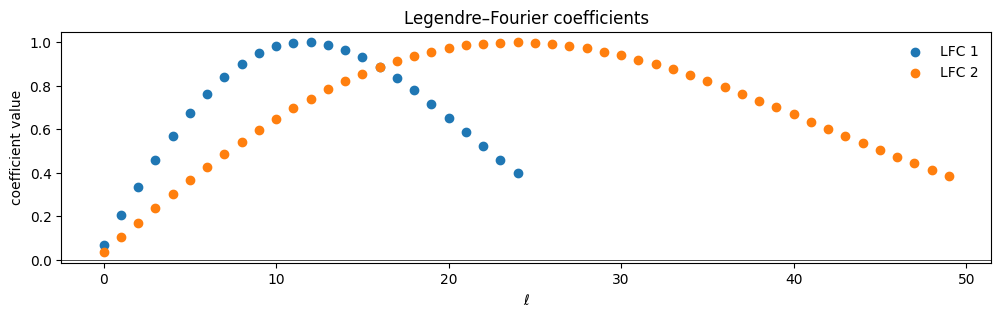

In [6]:
# Sink point for lfc precision 25 and 50 dim=3

l_prec, pool_size, dim, n_bm = 25, 1, 3, 4   # 2^(d-1)=4 bond moves
ctrl = RGControllerB2(l_prec, pool_size, dim, n_bm, bond_move_first=True)   # fresh object
ctrl.initialize_pool(J=10, p=0.0, q=0.0)
ctrl.step(10)
lfc25 = ctrl.get_pool()[0]


l_prec, pool_size, dim, n_bm = 50, 1, 3, 4   # 2^(d-1)=4 bond moves
ctrl = RGControllerB2(l_prec, pool_size, dim, n_bm, bond_move_first=True)   # fresh object
ctrl.initialize_pool(J=10, p=0.0, q=0.0)
ctrl.step(10)
lfc50 = ctrl.get_pool()[0]

fig, ax = plt.subplots(figsize=(12, 3))
plot_coefficients([lfc25, lfc50], ax=ax)

/Users/egementunca/rg-heisenberg/.venv/lib/python3.12/site-packages/mpl_toolkits/mplot3d/art3d.py:1403: RuntimeWarning: divide by zero encountered in matmul
  shade = ((normals / np.linalg.norm(normals, axis=1, keepdims=True))
/Users/egementunca/rg-heisenberg/.venv/lib/python3.12/site-packages/mpl_toolkits/mplot3d/art3d.py:1403: RuntimeWarning: overflow encountered in matmul
  shade = ((normals / np.linalg.norm(normals, axis=1, keepdims=True))


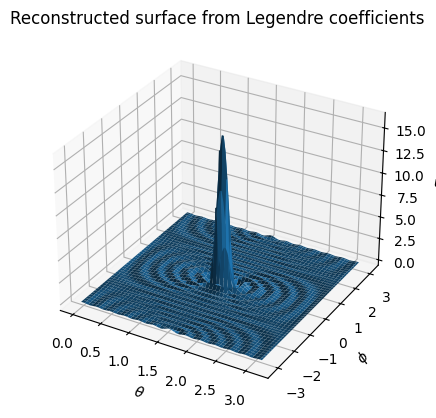

<Axes3D: title={'center': 'Reconstructed surface from Legendre coefficients'}, xlabel='$\\theta$', ylabel='$\\phi$', zlabel='$u$'>

In [34]:
plot_legendre_surface(lfc25)